<a href="https://colab.research.google.com/github/min0j98/mobis_aistudy_2023/blob/master/narnialabs_deepSDF2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필요한 라이브러리를 load합니다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

### 원에 대한 정의
sdf: (c,r)을 통해 정의한 원과 point 사이 거리

In [ ]:
class Shape:
    def sdf(self, p):
        pass

class Circle(Shape):

    def __init__(self, c, r):
        self.c = c
        self.r = r

    def sdf(self, p,**kwargs):
        return torch.tensor(np.linalg.norm(p - self.c) - self.r)


데이터의 학습 결과를 시각화하는 코드

In [ ]:
def plot_sdf(sdf_func):
    COORDINATES_LINSPACE = np.linspace(-4, 4, 100)
    y, x = np.meshgrid(COORDINATES_LINSPACE, COORDINATES_LINSPACE)
    z = np.float_([[sdf_func(np.float_([x_, y_])).detach().numpy()
                    for y_ in  COORDINATES_LINSPACE]
                    for x_ in COORDINATES_LINSPACE]).squeeze()
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    fig, ax = plt.subplots(figsize=(10, 10))
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.axis([x.min(), x.max(), y.min(), y.max()])

데이터 시각화

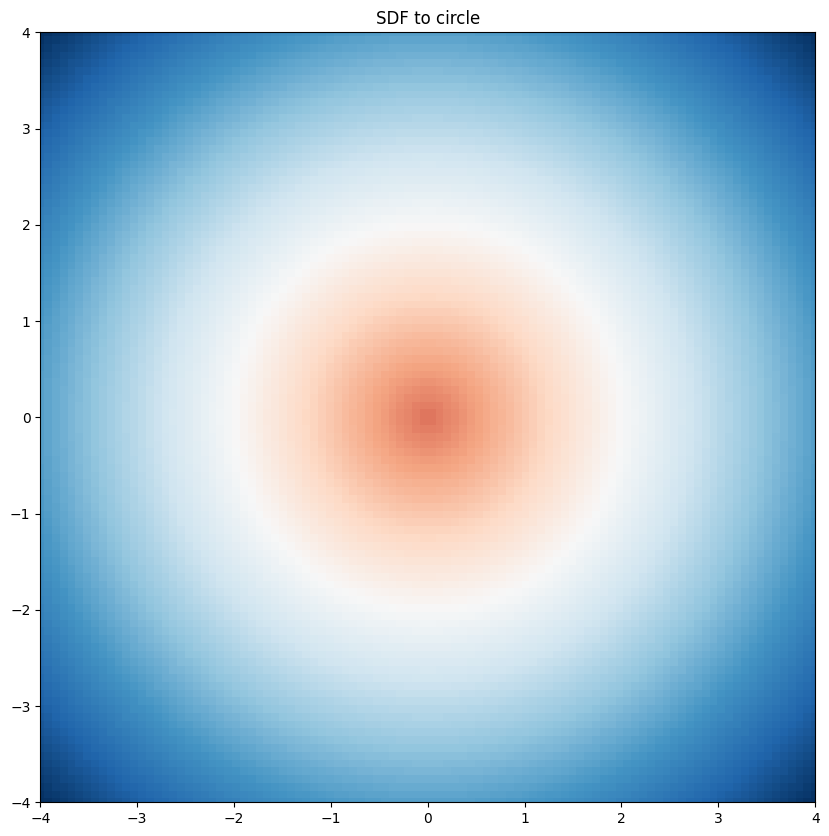

In [ ]:
# круг с центром в начале координат и радиусом 2
circle = Circle(np.float_([0, 0]), 2)
plot_sdf(circle.sdf)
plt.title("SDF to circle")
plt.show()

네트워크 구성

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):#, check = False):
        x = torch.Tensor(x)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
#        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)



$$ TRAIN := \{((x, y), s) : SDF(x, y) = s\} $$
훈련 샘플  생성. 점을 균일하게 샘플링


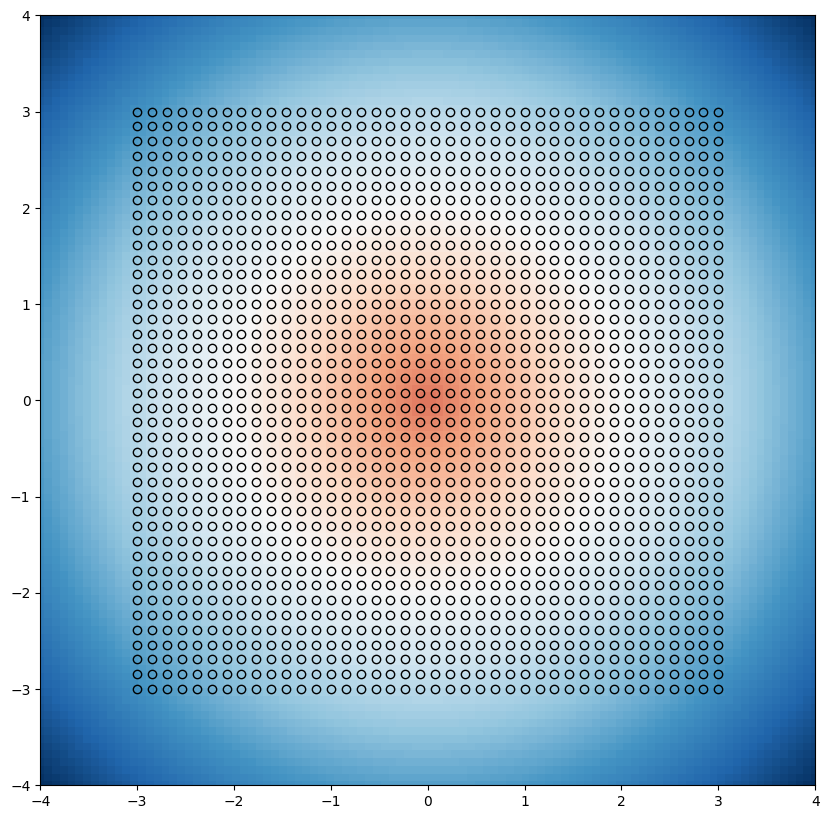

In [ ]:
points_train = np.float_([[x_, y_]
                    for y_ in  np.linspace(-3, 3, 40)
                    for x_ in np.linspace(-3, 3, 40)])
sdf_train = np.float_(list(map(circle.sdf, points_train)))

plot_sdf(circle.sdf)
plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#000000")

In [ ]:
sdf_train[sdf_train > 1] = 1
sdf_train[sdf_train < -1] = -1

데이터 로더

In [ ]:
train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

손실함수 `l1_loss`.
$$ Loss(net(x, y), sdf(x, y)) = |net(x, y) - sdf(x, y)| $$

DeepSDF 논문에서 활용하는 손실함수는 distance를 기준으로 clamp시킨 TSDF 학습
$$ Loss(net(x, y), sdf(x, y)) = |clamp(net(x, y), \delta) - clamp(sdf(x, y), \delta)| $$

이는 보다 중요한 데이터인 표면 근처 데이터를 집중적으로 학습하기 위함

In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
net = Net()
epochs = 2000
delta = 10
opt = optim.SGD(net.parameters(), lr=0.005)
scheduler = StepLR(opt, step_size=400, gamma=0.5)

pbar = tqdm(range(epochs))
loss_list = []
for epoch in pbar:
    net.train()
    total_loss = 0
    for points_b, sdfs_b in train_dl:
        pred = net(points_b)
        pred = pred.squeeze()
        loss = F.l1_loss(pred, sdfs_b)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()
    loss_list.append(total_loss.item())
    pbar.set_description("Epoch:{}, Loss: {}".format(epoch, total_loss.item()))

    # if (epoch % 2000 == 0):
    #     plot_sdf(net.forward)
    #     plt.show()



Epoch:1999, Loss: 0.059505000710487366: 100%|██████████| 2000/2000 [00:58<00:00, 34.18it/s]


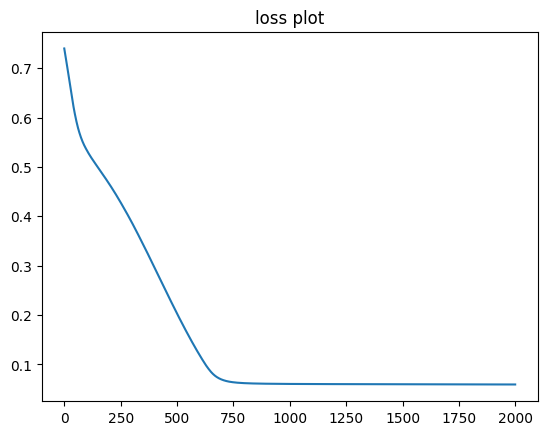

In [ ]:

plt.title("loss plot");
plt.plot(loss_list);

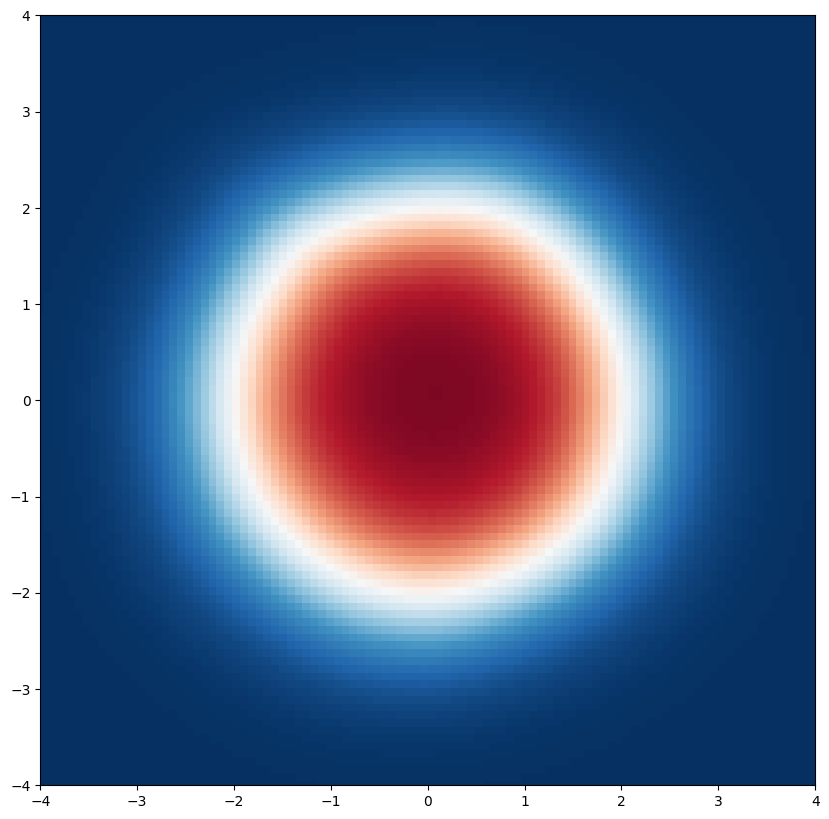

In [ ]:
plot_sdf(net.forward)
plt.show()

역전파를 통한 법선 계산

역전파를 사용하여 표면의 한 지점에서 법선을 계산할 수 있습니다. 실제로 법선은 부호 거리 함수의 기울기 방향입니다. 따라서 다음과 같이 법선을 계산할 수 있습니다.

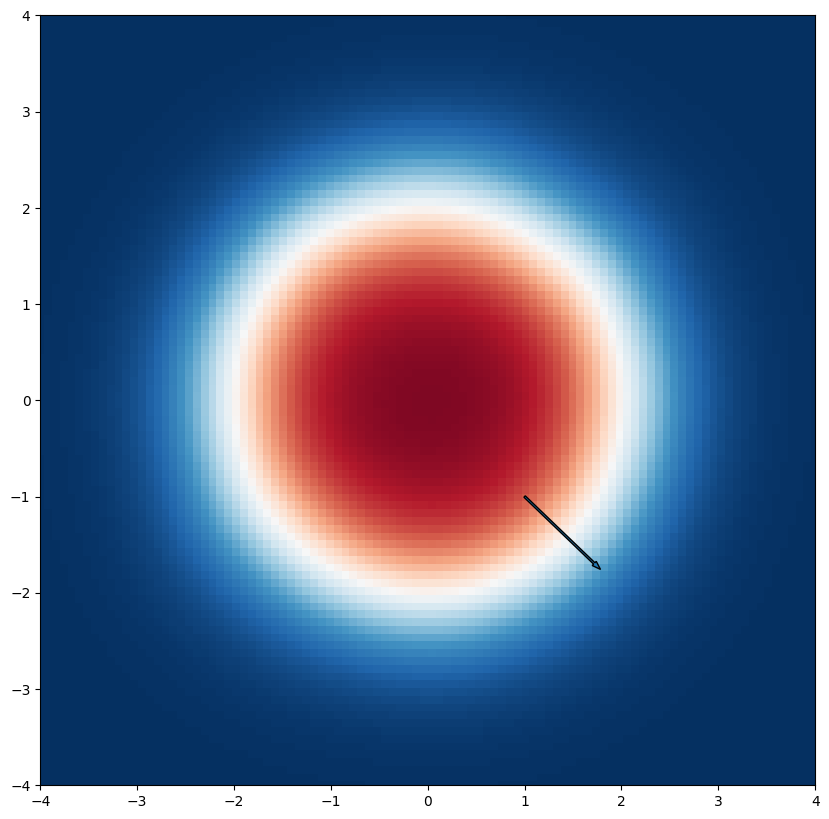

In [ ]:
p = torch.Tensor([1, -1])
p.requires_grad=True
my_sdf = net(p)
my_sdf.backward()
plot_sdf(net.forward)
plt.arrow(*p.detach().numpy(), *p.grad.detach().numpy() / np.linalg.norm(p.grad), width=0.02)

In [ ]:
reso = 100
COORDINATES_LINSPACE = np.linspace(-4, 4, reso)
y, x = np.meshgrid(COORDINATES_LINSPACE, COORDINATES_LINSPACE)
zz = []
for y_ in  COORDINATES_LINSPACE:
    for x_ in  COORDINATES_LINSPACE:
        p = torch.Tensor([x_, y_])
        p.requires_grad = True

        z = net(p)
        z.backward()
#        zn = p.grad.squeeze()#
        zn = np.linalg.norm(p.grad)
        zz = np.append(zz, zn)

In [ ]:
zz1 = zz.reshape(-1,2)


In [ ]:
zz1[0].shape

(2,)

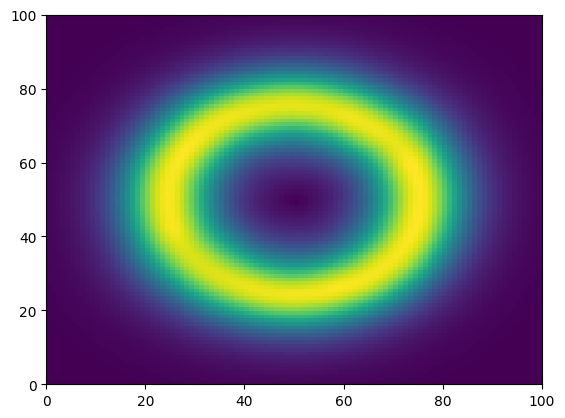

In [ ]:
plt.pcolor(zz.reshape(reso, reso))